# LFCA results

This notebook reproduces Fig. 2 for Ford and Rose (submitted 2025), as well as some supporting plots. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import matplotlib.path as mpath
from scipy.signal import correlate, correlation_lags, filtfilt, butter
import xarray as xr
from cartopy import crs as ccrs, feature as cfeature

In [2]:
def add_cyclic_point(xarray_obj, dim='lon', period=360):
    if period is None:
        period = xarray_obj.sizes[dim] / xarray_obj.coords[dim][:2].diff(dim).item()
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
    return xr.concat([xarray_obj, first_point], dim=dim)

In [3]:
hr_jlfca = xr.open_dataset('/roselab_rit/rford/iHESP-data/iHESP-HR.PICTRL.SO-JLFCA.1x1.nc')

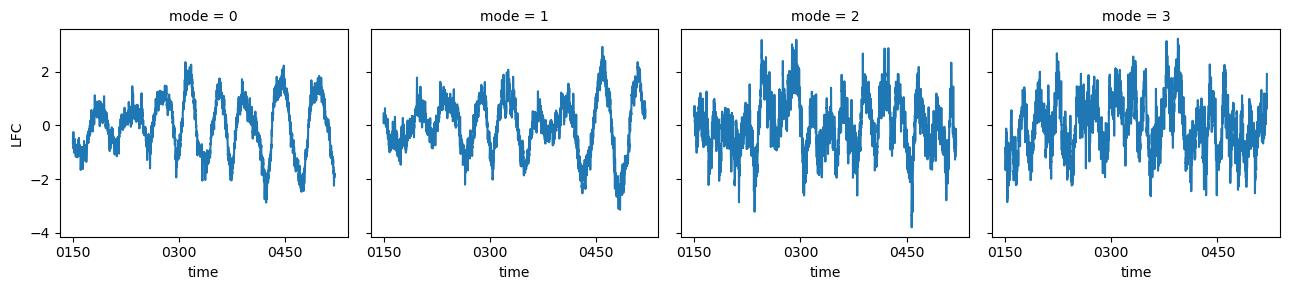

In [4]:
hr_jlfca.LFC.isel(mode=[0, 1, 2, 3], var=0).plot(col='mode')

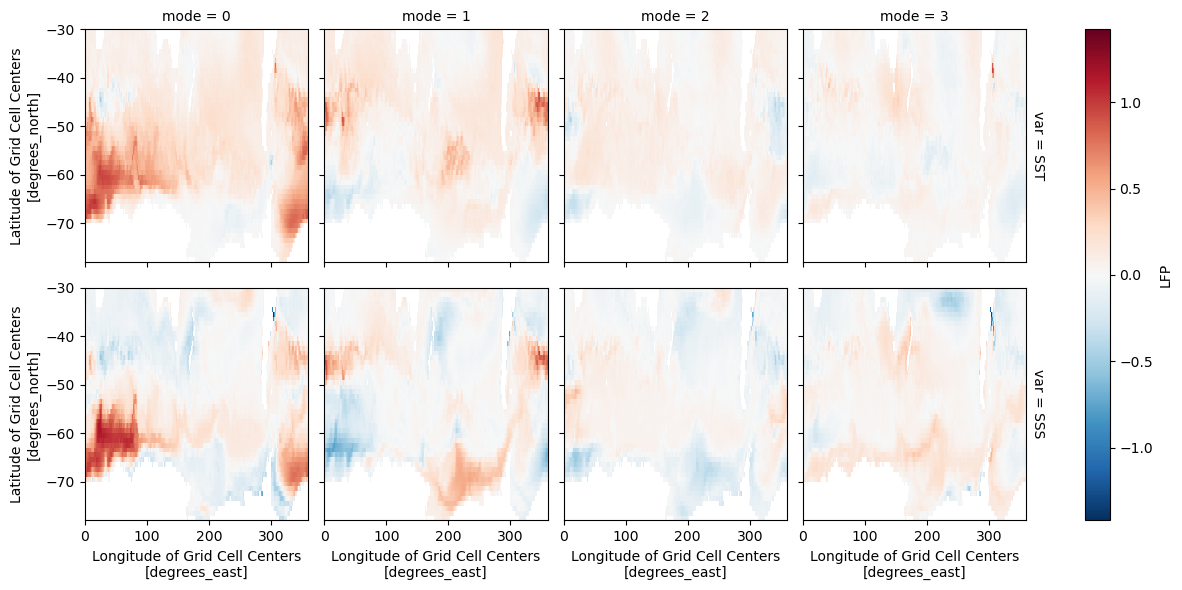

In [5]:
hr_jlfca.LFP.isel(mode=[0, 1, 2, 3]).plot(row='var', col='mode')

Text(0.015, 0.85, 'e')

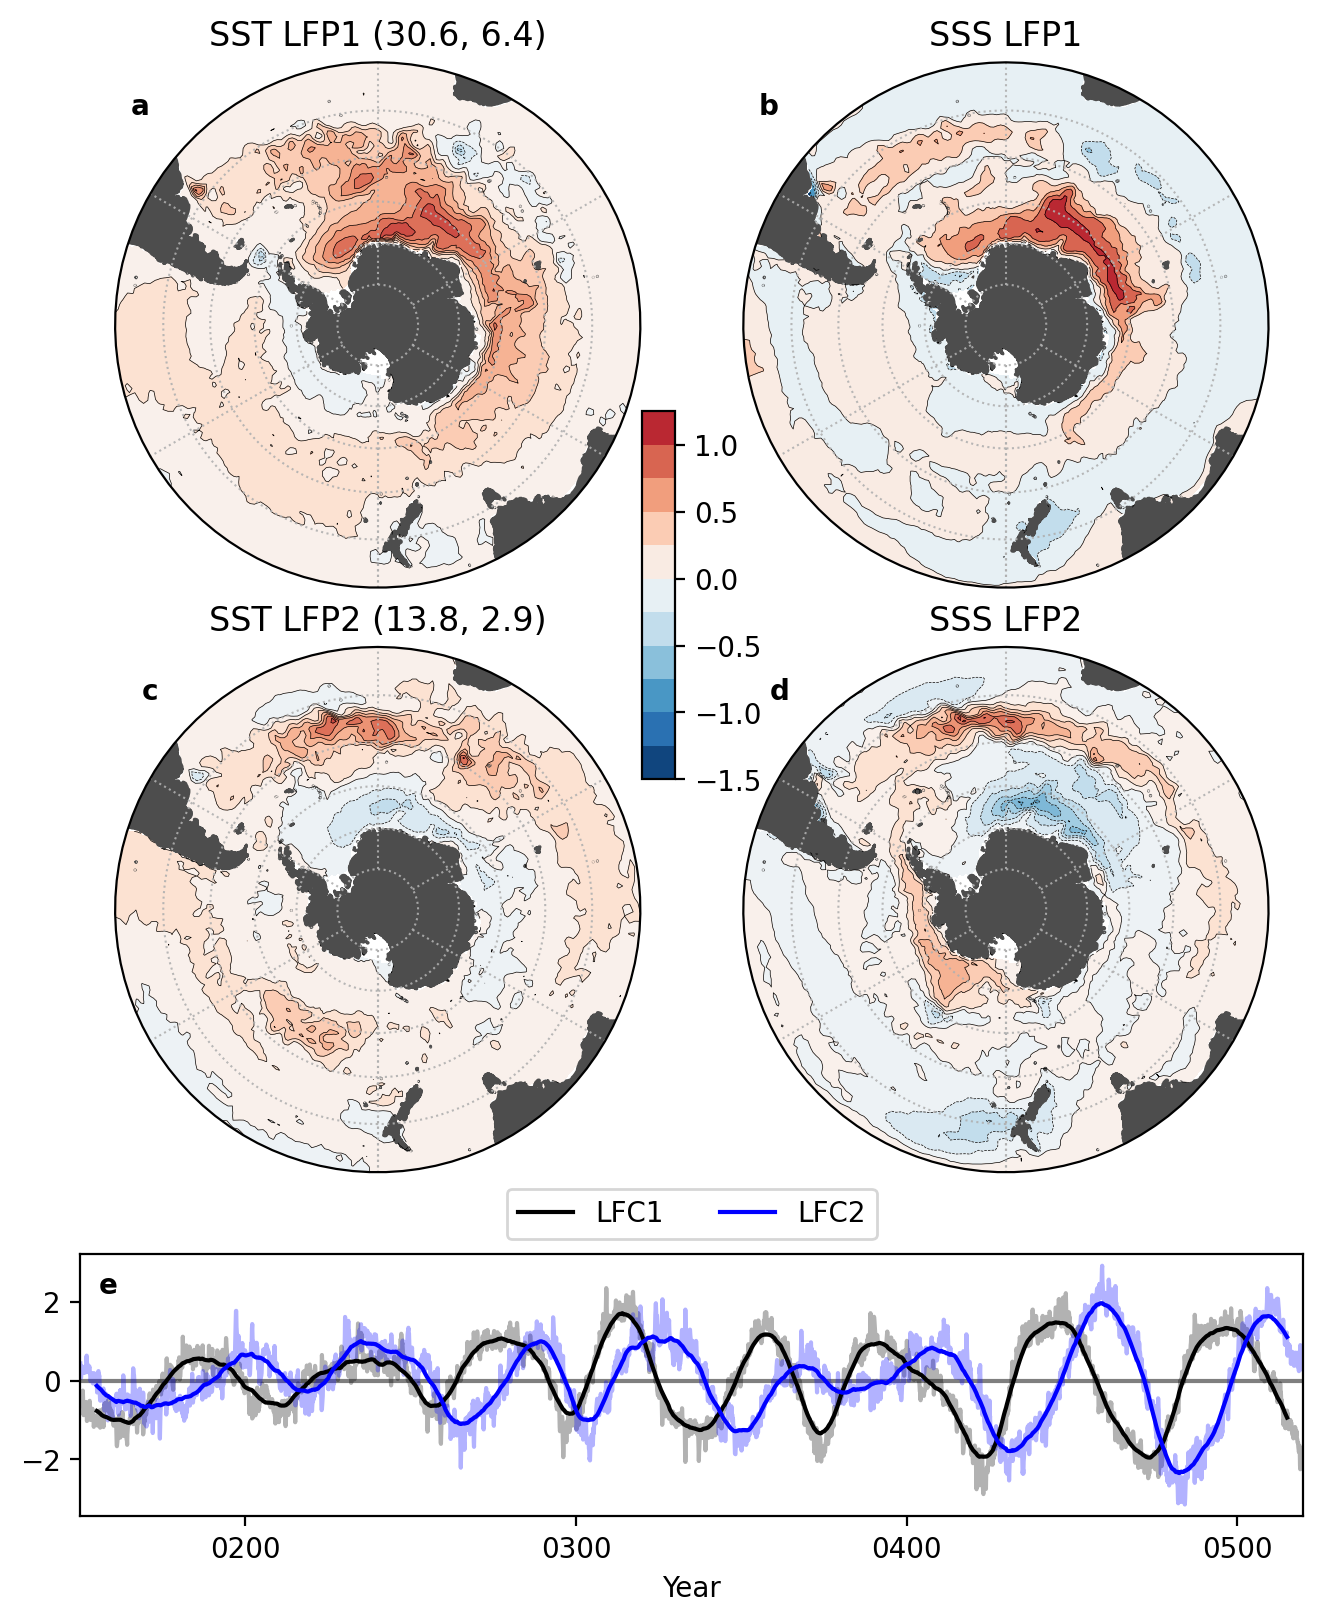

In [6]:
cyc_t_lfp0 = add_cyclic_point(hr_jlfca.LFP.isel(mode=0, var=0))
cyc_t_lfp1 = add_cyclic_point(hr_jlfca.LFP.isel(mode=1, var=0))
cyc_s_lfp0 = add_cyclic_point(hr_jlfca.LFP.isel(mode=0, var=1))
cyc_s_lfp1 = add_cyclic_point(hr_jlfca.LFP.isel(mode=1, var=1))

sp_proj = ccrs.SouthPolarStereo()
sp_proj._threshold /= 100.

fig2 = plt.figure(2, figsize=(6.5, 8), dpi=200, layout='constrained')
spec2 = fig2.add_gridspec(5, 4)
ax11 = fig2.add_subplot(spec2[0:2, 0:2], projection=sp_proj)
ax12 = fig2.add_subplot(spec2[2:4, 0:2], projection=sp_proj)
ax21 = fig2.add_subplot(spec2[0:2, 2:4], projection=sp_proj)
ax22 = fig2.add_subplot(spec2[2:4, 2:4], projection=sp_proj)
ax3 = fig2.add_subplot(spec2[4, :])
# ax3.set_aspect(1.1)

vlim = 1.5
lvls = 11
t_lfp0_plot = ax11.contourf(cyc_t_lfp0.lon, cyc_t_lfp0.lat, cyc_t_lfp0, transform=ccrs.PlateCarree(), levels=lvls, cmap='RdBu_r', norm=CenteredNorm(), vmin=-vlim, vmax=vlim)
t_lfp1_plot = ax12.contourf(cyc_t_lfp1.lon, cyc_t_lfp1.lat, cyc_t_lfp1, transform=ccrs.PlateCarree(), levels=lvls, cmap='RdBu_r', norm=CenteredNorm(), vmin=-vlim, vmax=vlim)
s_lfp0_plot = ax21.contourf(cyc_s_lfp0.lon, cyc_s_lfp0.lat, cyc_s_lfp0, transform=ccrs.PlateCarree(), levels=lvls, cmap='RdBu_r', norm=CenteredNorm(), vmin=-vlim, vmax=vlim)
s_lfp1_plot = ax22.contourf(cyc_s_lfp1.lon, cyc_s_lfp1.lat, cyc_s_lfp1, transform=ccrs.PlateCarree(), levels=lvls, cmap='RdBu_r', norm=CenteredNorm(), vmin=-vlim, vmax=vlim)

t_lfp0_lplot = ax11.contour(cyc_t_lfp0.lon, cyc_t_lfp0.lat, cyc_t_lfp0, transform=ccrs.PlateCarree(), levels=lvls, colors='k', linewidths=0.25, vmin=-vlim, vmax=vlim)
t_lfp1_lplot = ax12.contour(cyc_t_lfp1.lon, cyc_t_lfp1.lat, cyc_t_lfp1, transform=ccrs.PlateCarree(), levels=lvls, colors='k', linewidths=0.25, vmin=-vlim, vmax=vlim)
s_lfp0_lplot = ax21.contour(cyc_s_lfp0.lon, cyc_s_lfp0.lat, cyc_s_lfp0, transform=ccrs.PlateCarree(), levels=lvls, colors='k', linewidths=0.25, vmin=-vlim, vmax=vlim)
s_lfp1_lplot = ax22.contour(cyc_s_lfp1.lon, cyc_s_lfp1.lat, cyc_s_lfp1, transform=ccrs.PlateCarree(), levels=lvls, colors='k', linewidths=0.25, vmin=-vlim, vmax=vlim)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
for ax in [ax11, ax12, ax21, ax22]:
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=0.75, linestyle=':', alpha=0.9, ylim=80, ylocs=np.arange(-80, -39, 10))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), color='0.3')

cbar_ax = fig2.add_axes([0.485, 0.52, 0.025, 0.23])
fig2.colorbar(s_lfp0_plot, cax=cbar_ax, orientation='vertical')

ax11.set_title('SST LFP1 (%.1f, %.1f)' % (hr_jlfca.LFC_ESV.isel(mode=0, var=0).values, hr_jlfca.LFC_ETV.isel(mode=0, var=0).values))
ax12.set_title('SST LFP2 (%.1f, %.1f)' % (hr_jlfca.LFC_ESV.isel(mode=1, var=0).values, hr_jlfca.LFC_ETV.isel(mode=1, var=0).values))
ax21.set_title('SSS LFP1')
ax22.set_title('SSS LFP2')

ax3.plot(hr_jlfca.time, hr_jlfca.LFC.isel(mode=0, var=0), color='k', alpha=0.3)
ax3.plot(hr_jlfca.time, hr_jlfca.LFC.isel(mode=1, var=0), color='b', alpha=0.3)
ax3.plot(hr_jlfca.time, hr_jlfca.LFC.isel(mode=0, var=0).rolling(time=120, center=True).mean(), color='k', label='LFC1')
ax3.plot(hr_jlfca.time, hr_jlfca.LFC.isel(mode=1, var=0).rolling(time=120, center=True).mean(), color='b', label='LFC2')
ax3.axhline(0, linestyle='-', color='k', alpha=0.5, zorder=-1)
ax3.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', ncols=2)
ax3.set_xlim(hr_jlfca.time.min().values, hr_jlfca.time.max().values)
ax3.set_xlabel('Year')

ax11.annotate('a', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax12.annotate('c', xy=(0.05, 0.9), xycoords='axes fraction', fontweight='bold')
ax21.annotate('b', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
ax22.annotate('d', xy=(0.05, 0.9), xycoords='axes fraction', fontweight='bold')
ax3.annotate('e', xy=(0.015, 0.85), xycoords='axes fraction', fontweight='bold')

In [7]:
# fig2.savefig('lfca.png')

---

## SAM

In [8]:
def lpf(data, cutoff, fs, order=2, pad_len=100):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')

    pad_left = data[1:pad_len+1][::-1]
    pad_right = data[-pad_len-1:-1][::-1]
    padded = np.concatenate([pad_left, data, pad_right])

    filtered_padded = filtfilt(b, a, padded)
    return filtered_padded[pad_len:-pad_len]

def lpf_ufunc(da, cutoff_years=10, order=2, pad_len=100):
    fs = 1.0  # Monthly data
    cutoff = 1 / (cutoff_years * 12)

    return xr.apply_ufunc(lpf, da, kwargs={"cutoff": cutoff, "fs": fs, "order": order, "pad_len": pad_len})

def rolling_mean(da, t=120):
    return da.rolling(time=t, center=True).mean().dropna('time')

def calc_xcorr(x, y, mode='full'): 
    n = len(x)
    x = x - np.mean(x)
    y = y - np.mean(y)
    norm = np.std(x) * np.std(y) * len(x)
    c = correlate(x, y, mode)
    c = c/norm
    return c

In [9]:
psl = xr.open_dataset('/roselab_rit/rford/iHESP-data/iHESP-HR.PICTRL.PSL.1x1.250-520.nc')

In [10]:
sam = (psl.PSL.sel(lat=-40, method='nearest').mean(dim='lon') - psl.PSL.sel(lat=-65, method='nearest').mean(dim='lon'))/100

In [11]:
sam_lfc1_lagcorr = calc_xcorr(lpf_ufunc(sam).values, lpf_ufunc(hr_jlfca.LFC.isel(mode=0, var=0)).values, 'same')
lags_sam = correlation_lags(len(lpf_ufunc(sam).values), len(lpf_ufunc(hr_jlfca.LFC.isel(mode=0, var=0)).values), 'same')

sam_lfc1_lagcorr_rm = calc_xcorr(rolling_mean(sam).values, rolling_mean(hr_jlfca.LFC.isel(mode=0, var=0)).values, 'same')
lags_sam_rm = correlation_lags(len(rolling_mean(sam).values), len(rolling_mean(hr_jlfca.LFC.isel(mode=0, var=0)).values), 'same')

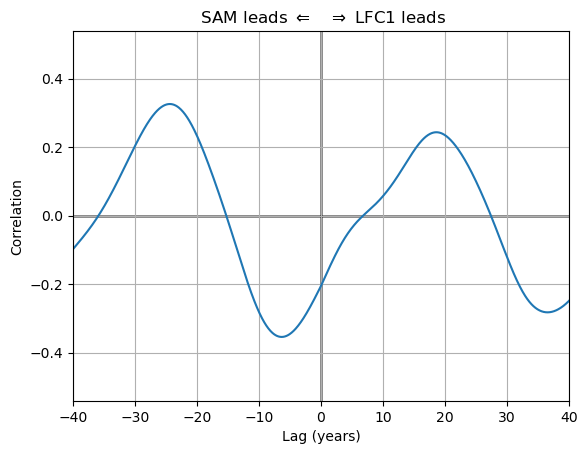

In [12]:
fig_sam = plt.figure()
plt.axvline(0, linestyle='-', color='k', alpha=0.5, linewidth=2, zorder=-1)
plt.axhline(0, linestyle='-', color='k', alpha=0.5, linewidth=2, zorder=-1)
plt.plot(lags_sam, sam_lfc1_lagcorr)
plt.xticks(np.arange(-480, 481, 120), [f'{x}'.replace('-', '\N{MINUS SIGN}') for x in np.arange(-40, 41, 10)])
plt.xlim(-480, 480)
plt.xlabel('Lag (years)')
plt.ylabel('Correlation')
plt.title(r'   SAM leads $\Leftarrow$   $\Rightarrow$ LFC1 leads   ')
plt.grid()

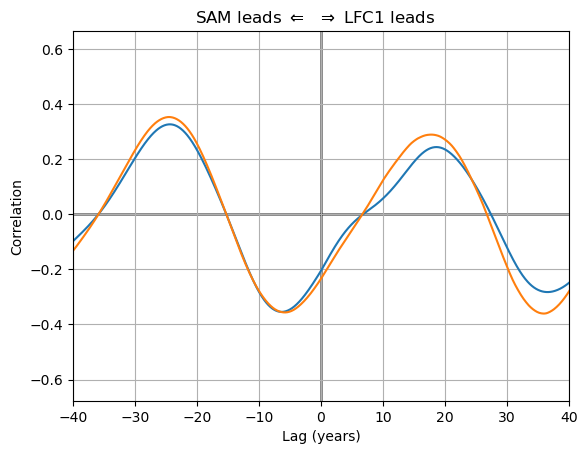

In [16]:
plt.axvline(0, linestyle='-', color='k', alpha=0.5, linewidth=2, zorder=-1)
plt.axhline(0, linestyle='-', color='k', alpha=0.5, linewidth=2, zorder=-1)
plt.plot(lags_sam, sam_lfc1_lagcorr)
plt.plot(lags_sam_rm, sam_lfc1_lagcorr_rm)
plt.xticks(np.arange(-480, 481, 120), [f'{x}'.replace('-', '\N{MINUS SIGN}') for x in np.arange(-40, 41, 10)])
plt.xlim(-480, 480)
plt.xlabel('Lag (years)')
plt.ylabel('Correlation')
plt.title(r'SAM leads $\Leftarrow$  $\Rightarrow$ LFC1 leads   ')
plt.grid()

In [14]:
# fig_sam.savefig('si-sam.png')